# 🏋️ Calorie Expenditure Prediction  
### Kaggle Playground Series - Season 5, Episode 5

> A full ML pipeline for predicting calorie expenditure from physiological and exercise metrics using XGBoost, Random Forest, SHAP, and cross-validation.

---

**📅 Date:** June 2025  
**👩‍💻 Author:** [Poulami Nandi](https://www.linkedin.com/in/poulami-nandi)  
**📁 GitHub:** [github.com/Poulami-Nandi](https://github.com/Poulami-Nandi)  
**🏆 Kaggle Competition:** [Playground S5E5](https://www.kaggle.com/competitions/playground-series-s5e5)

---

📌 **Notebook Overview:**
- 📊 Exploratory Data Analysis (EDA)
- 🧹 Preprocessing & Feature Engineering
- 🔁 Cross-Validation Setup
- 🧠 Model Training (Linear, RF, XGBoost)
- 🔧 Hyperparameter Tuning
- 🧾 Submission Generation
- 🔍 SHAP Model Explainability

---


## EDA

### Step 1: Basic Overview and Summary Statistics

We begin the exploratory data analysis by loading the dataset and inspecting its structure. We also generate basic descriptive statistics to understand the central tendency, spread, and presence of any anomalies in the dataset.

In [1]:
import pandas as pd

# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

# Basic info
print("Training Data Info:")
print(train_df.info())

# Descriptive statistics
train_df.describe()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB
None


,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


### 📊 Step 2: Visualizing Feature Distributions

This step helps in identifying the data distribution (normal, skewed, etc.) for all numerical features. We use histograms with KDE to visualize the spread and shape of each variable's distribution.


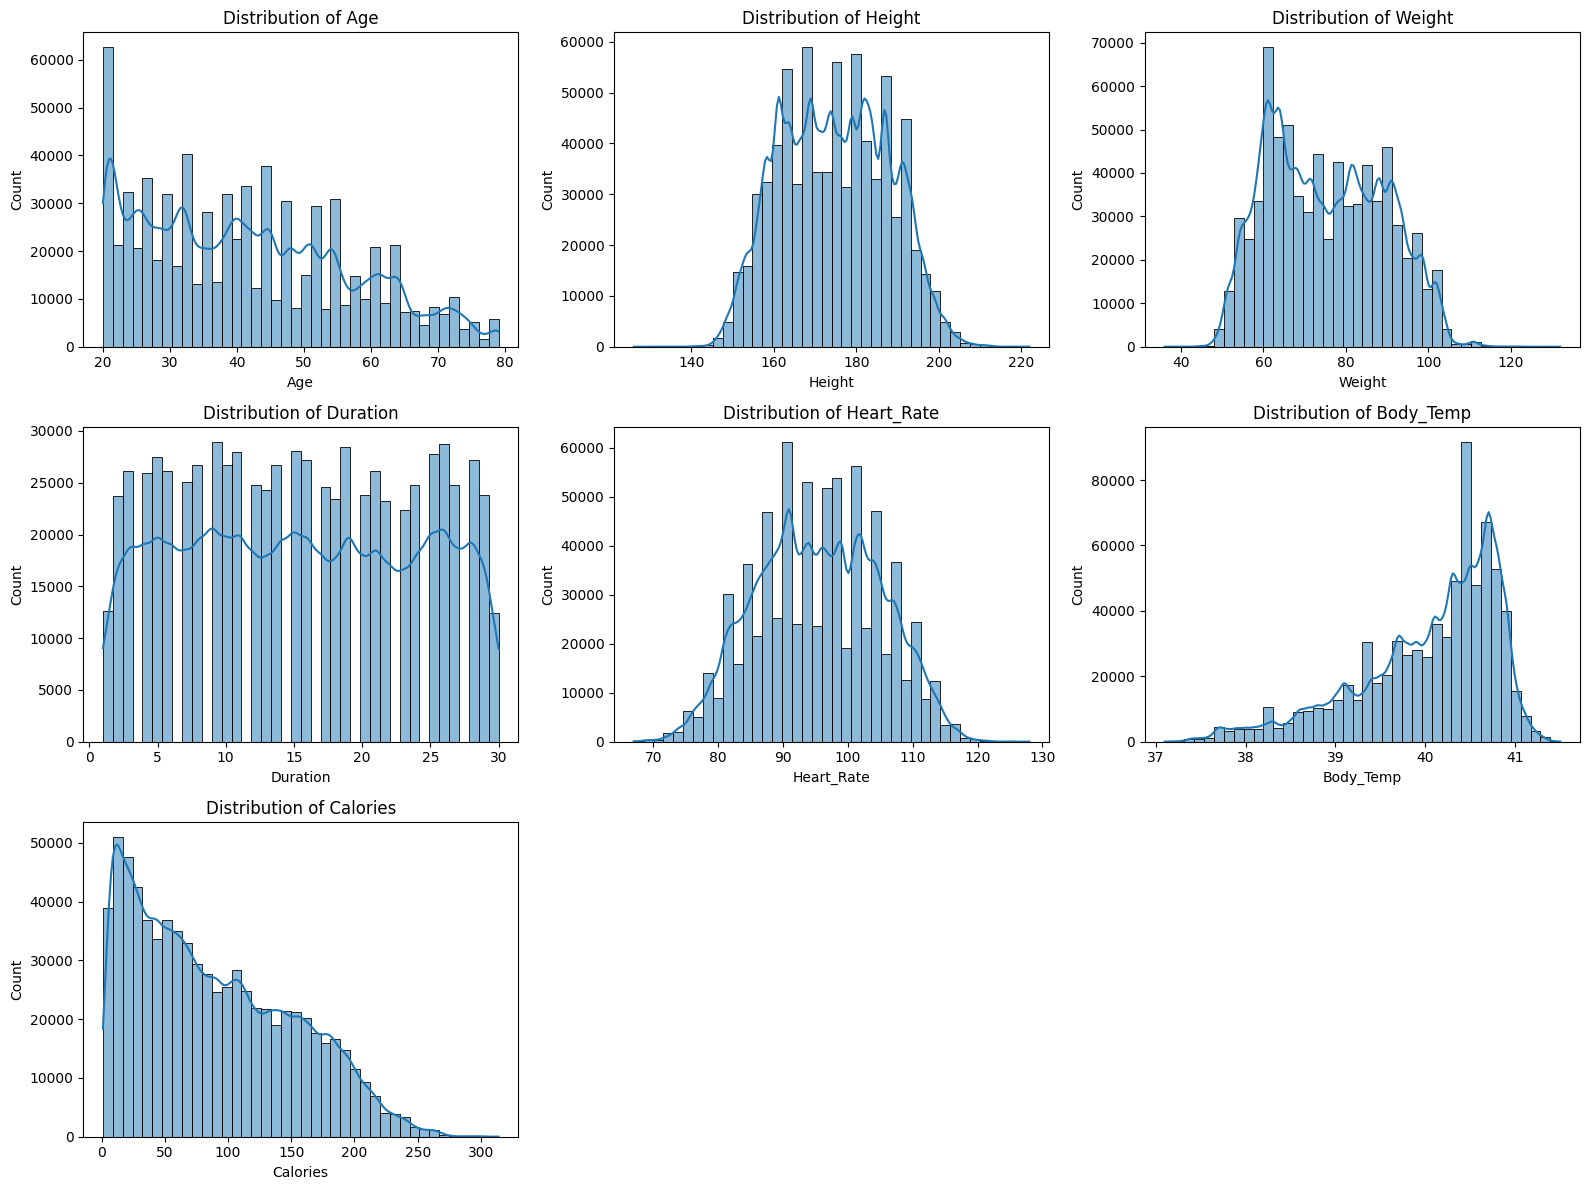

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical features including the target
numerical_features = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

# Plot histograms with KDE
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(train_df[feature], kde=True, bins=40)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


### Step 3: Detecting Outliers using Boxplots

Boxplots help us visually identify the presence of outliers and the spread of each numeric feature (except the target variable here). Extreme values can influence the training of some models and might need special treatment.


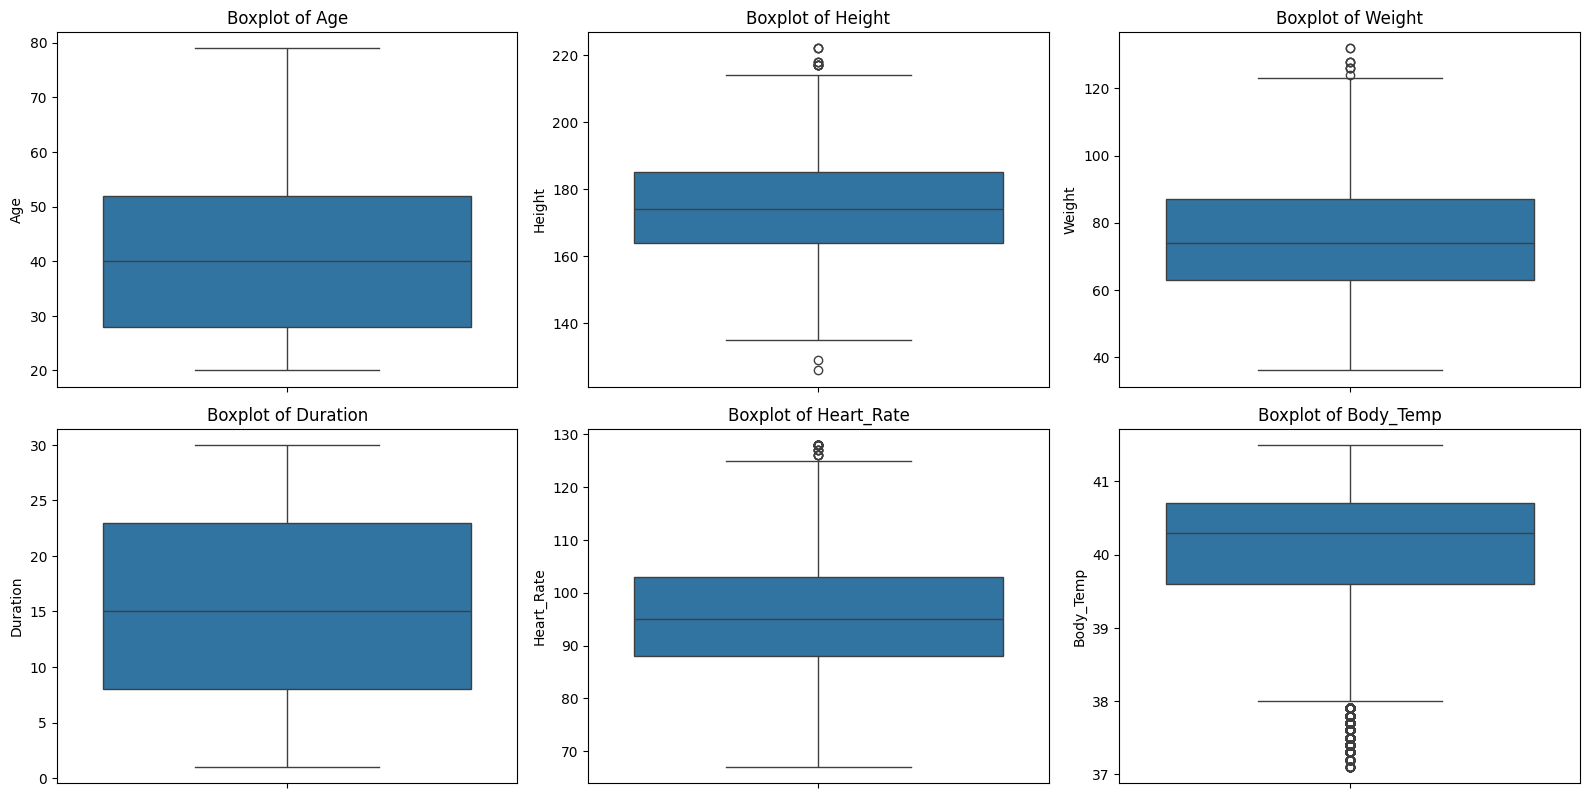

In [3]:
# Boxplots (excluding the target variable)
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features[:-1]):  # Exclude 'Calories'
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=train_df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()


### Step 4: Correlation Heatmap

Correlation matrices help us understand the linear relationships between numerical features and the target variable (`Calories`). This helps prioritize important features for modeling.


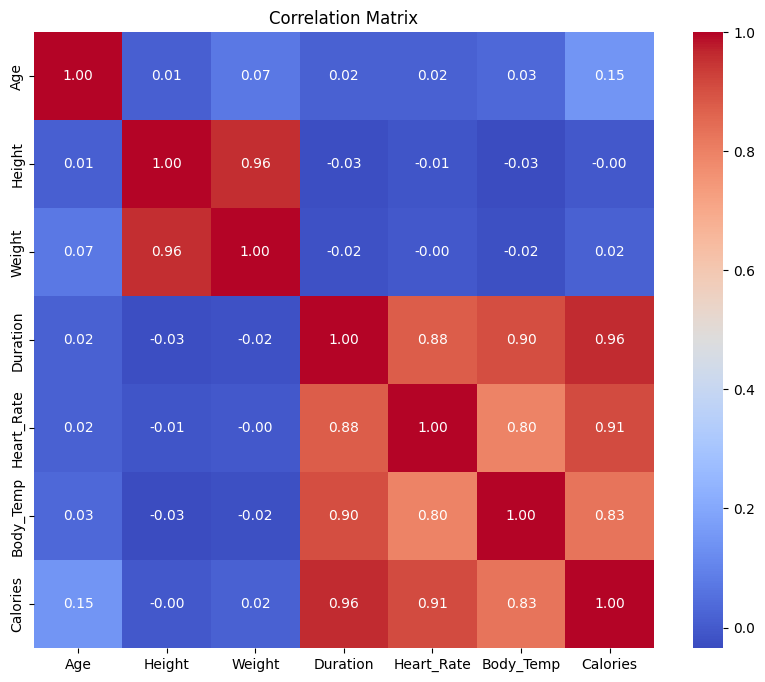

In [4]:
# Compute correlation matrix
correlation_matrix = train_df[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


### 📈 Step 5: Distribution of Target Variable with Log Transformation

The target variable `Calories` is right-skewed. Applying a log transformation can help normalize it, which may improve model performance in some cases. We visualize both the raw and log-transformed distributions.


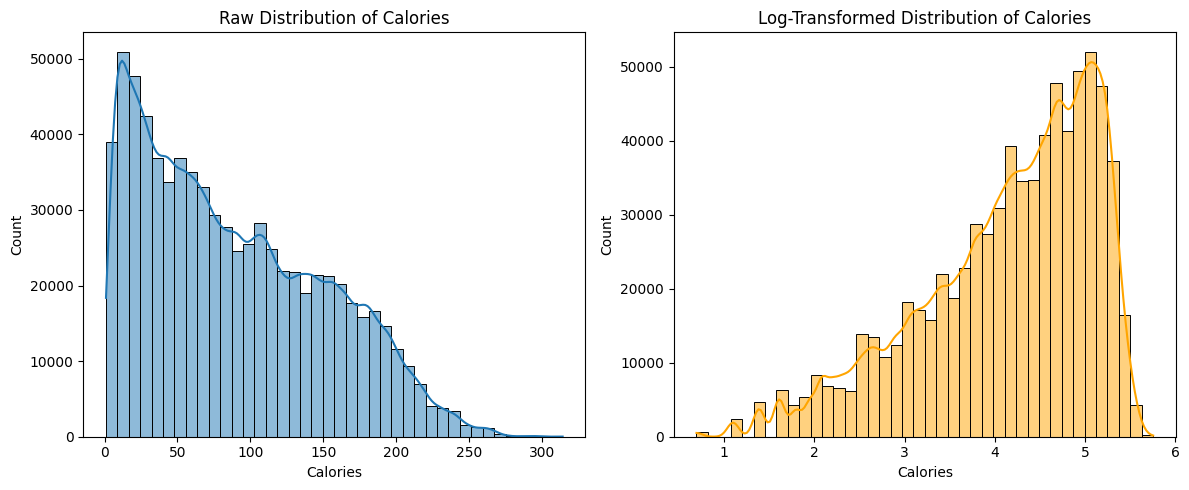

In [5]:
import numpy as np

# Plot raw and log-transformed Calories
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df['Calories'], bins=40, kde=True)
plt.title("Raw Distribution of Calories")

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train_df['Calories']), bins=40, kde=True, color="orange")
plt.title("Log-Transformed Distribution of Calories")

plt.tight_layout()
plt.show()

### Step 6: Group-wise Summary by Categorical Feature (`Sex`)

This step shows how the average values of features differ between males and females, including how Calories vary. We use groupby and aggregation to summarize the differences.

In [6]:
# Group by Sex and show mean values
grouped_by_sex = train_df.groupby('Sex')[['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']].mean()
grouped_by_sex

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
Sex,,,,,,,
female,41.273650,165.022200,63.726300,15.501013,95.397955,40.048655,87.534761
male,41.567724,184.410448,86.609032,15.340708,95.570366,40.023803,89.033683


### Step 7: Pairwise Relationships with Seaborn Pairplot

Pairplots show scatterplots and distributions for combinations of features and the target. This helps us identify trends, clusters, or collinearities.

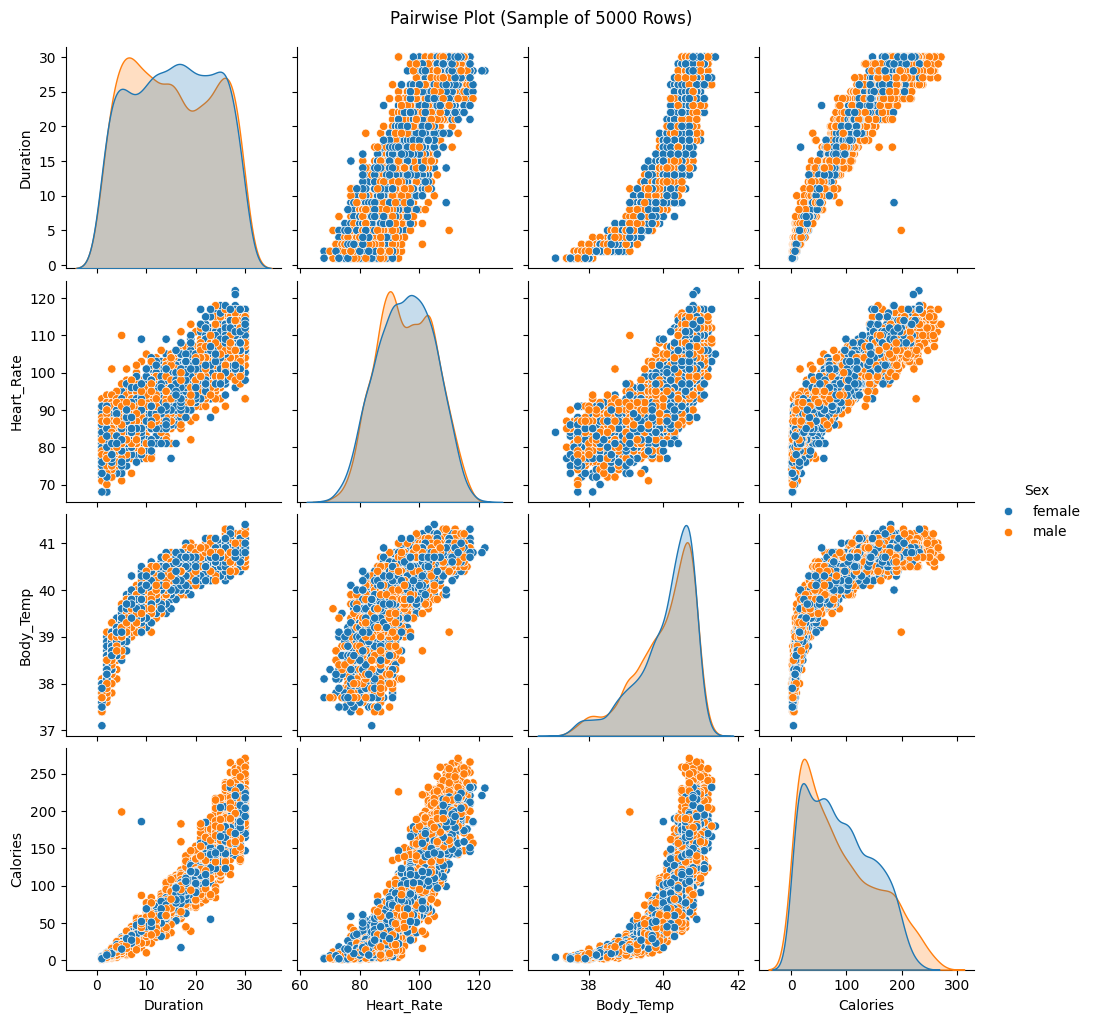

In [7]:
# Due to large size, use a sample for pairplot
sample_df = train_df.sample(5000, random_state=42)

sns.pairplot(sample_df, vars=['Duration', 'Heart_Rate', 'Body_Temp', 'Calories'], hue='Sex')
plt.suptitle("Pairwise Plot (Sample of 5000 Rows)", y=1.02)
plt.show()

### Step 8: Violin Plots of Numerical Features by Sex

Violin plots show the distribution and spread of numerical features for male vs female. This can reveal sex-based differences in physical attributes or calorie burn.

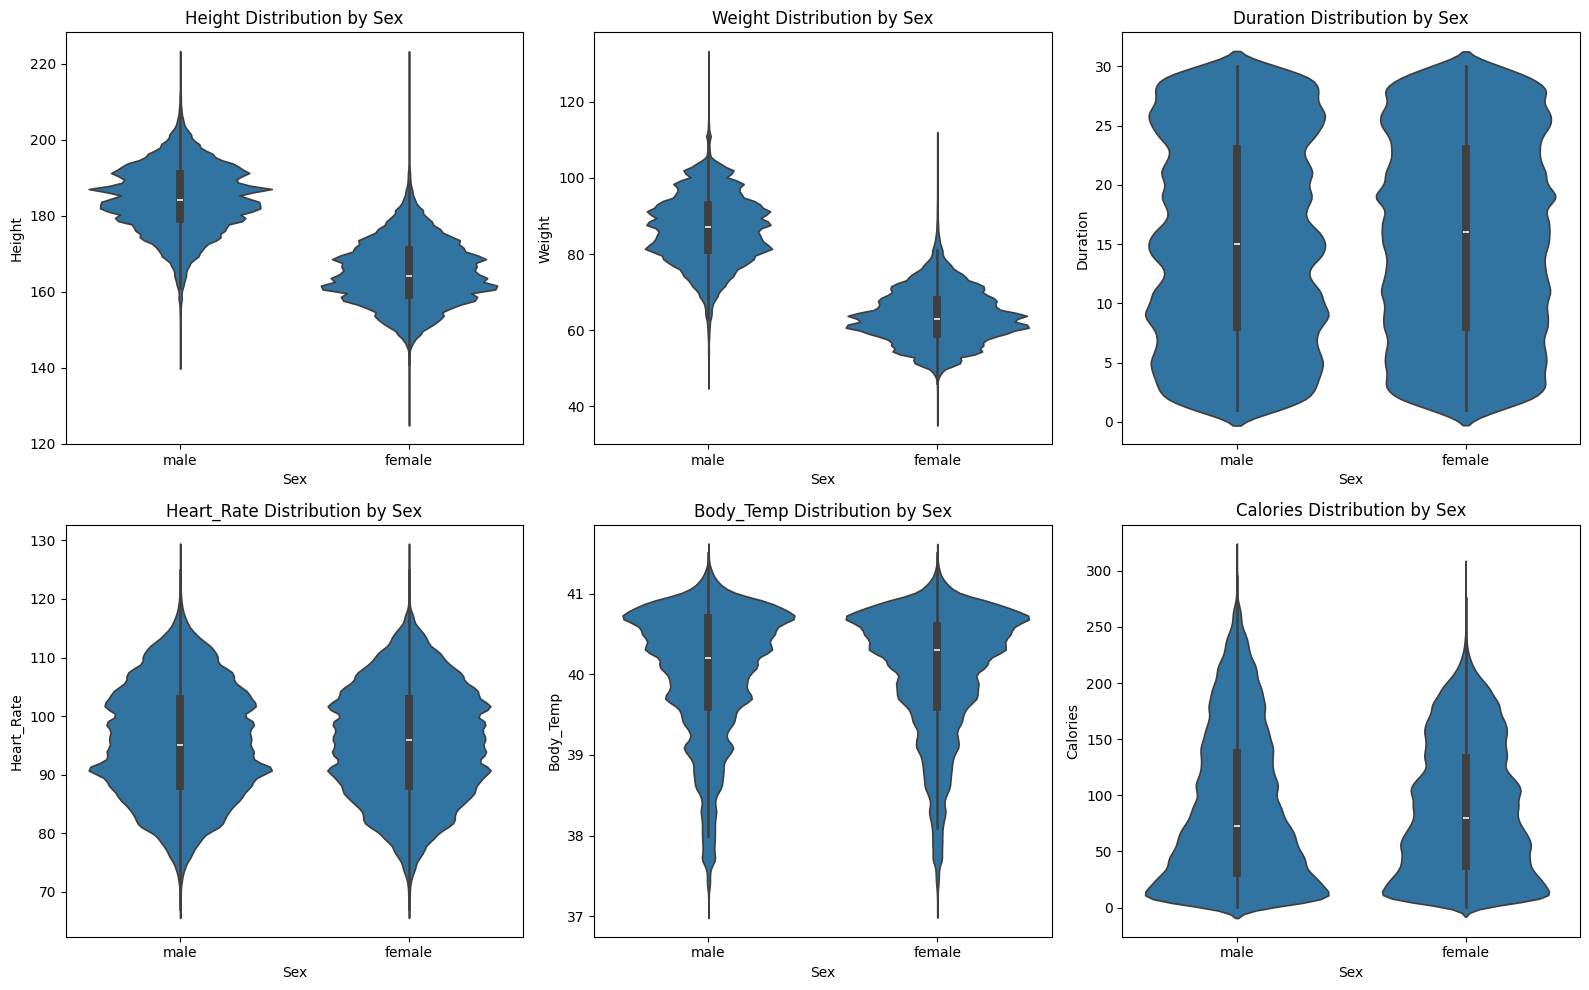

In [8]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']):
    plt.subplot(2, 3, i + 1)
    sns.violinplot(data=train_df, x='Sex', y=col)
    plt.title(f'{col} Distribution by Sex')
plt.tight_layout()
plt.show()

### Step 9: Missing Value Check

It's essential to check for missing or null values before preprocessing or modeling. We check across the entire training and test datasets.


In [9]:
print("Missing values in train dataset:")
print(train_df.isnull().sum())

print("\nMissing values in test dataset:")
print(test_df.isnull().sum())

Missing values in train dataset:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

Missing values in test dataset:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64


## Preprocessing

### Step 1: Encode Categorical Feature `Sex`

The `Sex` column is categorical (`male`/`female`). We'll use Label Encoding (`male` → 1, `female` → 0) since this is a binary variable.


In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode 'Sex'
le = LabelEncoder()
train_df['Sex'] = le.fit_transform(train_df['Sex'])
test_df['Sex'] = le.transform(test_df['Sex'])  # Use same encoder

### Step 2: Log Transform the Target Variable `Calories`

Since `Calories` is skewed, we optionally apply a `log1p` transformation to make the distribution more normal. This can improve performance in regression tasks.


In [11]:
# Apply log1p transformation
train_df['Calories_log'] = np.log1p(train_df['Calories'])

### Step 3: Feature Scaling

We apply standardization (`z = (x - mean) / std`) to numerical features to ensure uniform scaling. This is especially important for models like linear regression or neural networks.


In [12]:
from sklearn.preprocessing import StandardScaler

# List of features to scale
features_to_scale = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

# Initialize scaler and fit on training data
scaler = StandardScaler()
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

### Step 4: Final Feature Matrix and Target Vector

We define the final `X_train`, `X_test`, and `y_train` to be used in model training and evaluation.

In [13]:
# Use log-transformed or original target
USE_LOG_TARGET = True

# Feature matrix
X_train = train_df[['Sex'] + features_to_scale]
X_test = test_df[['Sex'] + features_to_scale]

# Target variable
y_train = train_df['Calories_log'] if USE_LOG_TARGET else train_df['Calories']

## RMSE and CV setup

### Step 1: Define Evaluation Metric (Root Mean Squared Error)

Root Mean Squared Error (RMSE) is the competition's metric. Lower RMSE indicates better predictions. We use `mean_squared_error` from `sklearn` and wrap it in a function.


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


### Step 2: Set Up K-Fold Cross-Validation

We use K-Fold cross-validation to split the training data into multiple folds, ensuring our model generalizes well. You can set `n_splits` to control the number of folds.


In [15]:
from sklearn.model_selection import KFold

# Set number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Preview: print indices of one fold (optional)
for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1} - Train size: {len(train_idx)}, Valid size: {len(valid_idx)}")
    break  # remove this line to print all folds


Fold 1 - Train size: 600000, Valid size: 150000


### Step 3: CV Runner Function

This function accepts a regression model, performs K-Fold cross-validation, and prints the RMSE for each fold and the average.


In [16]:
def run_cv(model, X, y, kf, use_log_target=True):
    fold_rmse = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        if use_log_target:
            # Reverse log transformation
            preds = np.expm1(preds)
            y_val = np.expm1(y_val)

        score = rmse(y_val, preds)
        fold_rmse.append(score)
        print(f"Fold {fold + 1}: RMSE = {score:.4f}")

    print(f"\nAverage RMSE: {np.mean(fold_rmse):.4f}")


## ML models

### Step 1: Linear Regression Baseline

We start with a simple linear regression model as a baseline. This helps understand whether a linear relationship is sufficient to explain calorie expenditure based on the input features.


In [17]:
from sklearn.linear_model import LinearRegression

# Instantiate model
lr_model = LinearRegression()

# Run cross-validation
print("Linear Regression Performance:")
run_cv(lr_model, X_train, y_train, kf, use_log_target=USE_LOG_TARGET)

Linear Regression Performance:
Fold 1: RMSE = 18.0062
Fold 2: RMSE = 18.2090
Fold 3: RMSE = 18.0018
Fold 4: RMSE = 18.0611
Fold 5: RMSE = 17.9134

Average RMSE: 18.0383


### Step 2: Random Forest Regressor Baseline

Random Forest is a non-linear ensemble method that usually performs well out-of-the-box. It helps us gauge how much performance gain we can get from tree-based methods over linear models.


In [18]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Run cross-validation
print("Random Forest Regressor Performance:")
run_cv(rf_model, X_train, y_train, kf, use_log_target=USE_LOG_TARGET)


Random Forest Regressor Performance:
Fold 1: RMSE = 5.4785
Fold 2: RMSE = 5.5540
Fold 3: RMSE = 5.5331
Fold 4: RMSE = 5.5676
Fold 5: RMSE = 5.4693

Average RMSE: 5.5205


### Step 3: XGBoost Regressor Baseline

XGBoost is a high-performance gradient boosting algorithm that often outperforms simpler tree-based models. It's efficient and highly customizable. We test it here with basic settings as a new baseline.


In [19]:
!pip install -q xgboost

import xgboost as xgb
from xgboost import XGBRegressor

# Instantiate XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Run cross-validation
print("XGBoost Regressor Performance:")
run_cv(xgb_model, X_train, y_train, kf, use_log_target=USE_LOG_TARGET)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.3 MB/s eta 0:00:00
XGBoost Regressor Performance:
Fold 1: RMSE = 3.8201
Fold 2: RMSE = 3.9018
Fold 3: RMSE = 3.8588
Fold 4: RMSE = 3.7679
Fold 5: RMSE = 3.8052

Average RMSE: 3.8308


## Hyperparameter Tuning

### Step 1: Hyperparameter Tuning for Random Forest

We use GridSearchCV to tune key hyperparameters for Random Forest: `n_estimators`, `max_depth`, and `min_samples_split`. The scoring metric is negative RMSE (as required by scikit-learn).

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# Base model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid Search
rf_grid = GridSearchCV(
    rf_base,
    rf_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=kf,
    verbose=1,
    n_jobs=-1
)

# Fit the model
rf_grid.fit(X_train, y_train)

# Best parameters and score
print("Best RF Parameters:", rf_grid.best_params_)
print("Best RF RMSE Score:", -rf_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best RF Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best RF RMSE Score: 0.06268156822692648


### Step 2: Hyperparameter Tuning for XGBoost

We tune `n_estimators`, `max_depth`, and `learning_rate` for XGBoost using GridSearchCV. Like before, scoring is set to RMSE.

In [21]:
from xgboost import XGBRegressor

# Parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1]
}

# Base model
xgb_base = XGBRegressor(
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Grid Search
xgb_grid = GridSearchCV(
    xgb_base,
    xgb_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=kf,
    verbose=1,
    n_jobs=-1
)

# Fit the model
xgb_grid.fit(X_train, y_train)

# Best parameters and score
print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost RMSE Score:", -xgb_grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best XGBoost Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
Best XGBoost RMSE Score: 0.05998441570772456


## Model Training & Prediction

### Step 1: Train Final Model Using Best Parameters

Using the best hyperparameters found in GridSearchCV, we retrain the full model on the entire training dataset. This version will be used to predict calorie values for the test set.

In [22]:
# selected xgboost as it has better rmse

final_model = xgb_grid.best_estimator_

# Train on the entire training data
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

### Step 2: Generate Predictions on Test Set

We now use the trained model to predict the calorie expenditure for the test data. If log transformation was applied earlier, we reverse it using `np.expm1`.


In [23]:
# Predict
test_preds = final_model.predict(X_test)

# Reverse log transformation if applied
if USE_LOG_TARGET:
    test_preds = np.expm1(test_preds)

# Ensure no negative predictions
test_preds = np.clip(test_preds, 0, None)

### Step 3: Create Submission CSV File

We prepare the submission file in the required format: two columns — `id` and `Calories`. This file can be directly uploaded to Kaggle.


In [24]:
# Prepare submission
submission = sample_submission_df.copy()
submission['Calories'] = test_preds

# Save to CSV
submission.to_csv('submission.csv', index=False)
submission.head()

,id,Calories
0,750000,27.346346
1,750001,107.249344
2,750002,88.470795
3,750003,126.565865
4,750004,76.404640


## Analysis of Important features

### 📊 Step 1: Visualize Feature Importances

Feature importances help us understand which input variables the model relied on most. Tree-based models like Random Forest and XGBoost provide built-in feature importance scores.

<ipython-input-25-31382a596ead>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


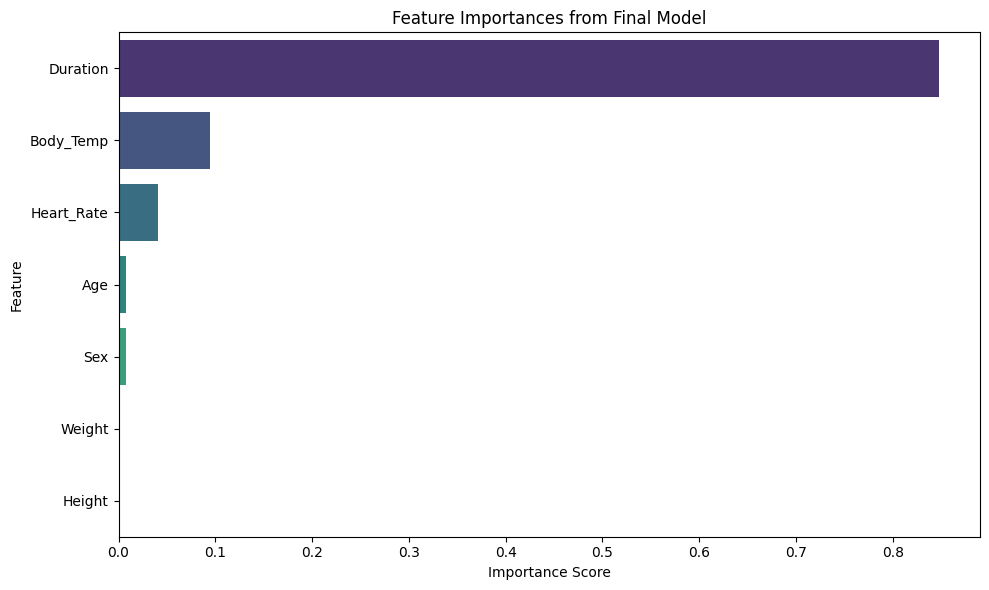

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances and feature names
importances = final_model.feature_importances_
features = X_train.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances from Final Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Model Interpretability analysis

### Step 1: Install and Initialize SHAP

SHAP (SHapley Additive exPlanations) explains how much each feature contributes to the model's prediction. We install the `shap` package and initialize an explainer using the trained model.


In [26]:
!pip install -q shap

import shap

# Enable JS visualization in notebooks
shap.initjs()

# Use a sample of the data to speed up SHAP computation
X_sample = X_train.sample(500, random_state=42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.5 MB/s eta 0:00:00


### Step 2: Compute SHAP Values

SHAP values are calculated for a subset of the training data to avoid high memory consumption. This step might take a few seconds to complete.


In [27]:
# Create SHAP explainer for tree-based model
explainer = shap.Explainer(final_model, X_sample)
shap_values = explainer(X_sample)

### Step 3: SHAP Summary Plot

This plot shows the impact of each feature across the dataset. It helps identify which features consistently drive predictions higher or lower.

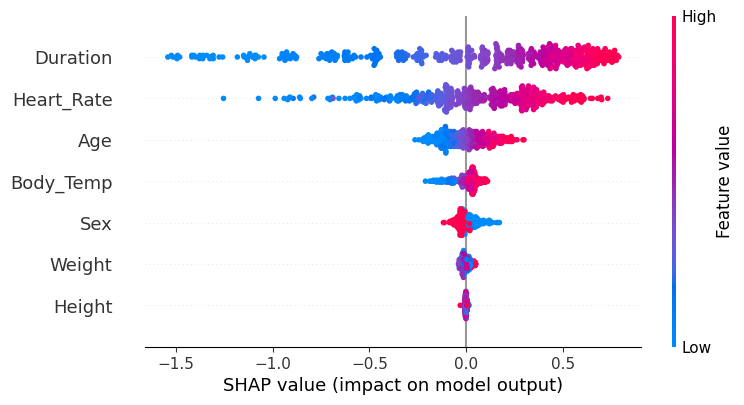

In [28]:
# Summary plot: shows feature impact, importance, and direction
shap.plots.beeswarm(shap_values)

### 📊 Step 4: SHAP Feature Importance (Bar)

This bar chart shows average absolute SHAP values for each feature — a global importance view.

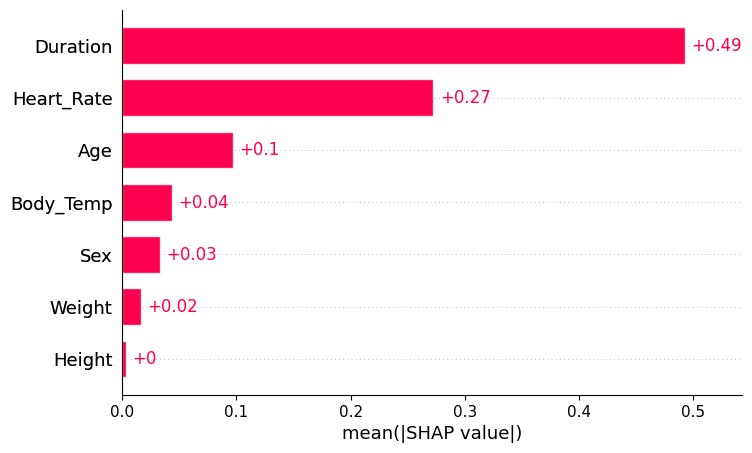

In [29]:
shap.plots.bar(shap_values)

### Step 5: SHAP Force Plot

This shows how features contribute to a specific prediction. Positive (red) values increase prediction, while negative (blue) reduce it.

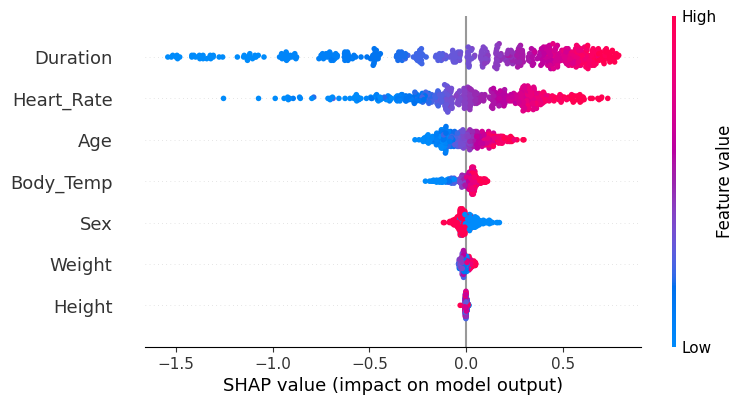

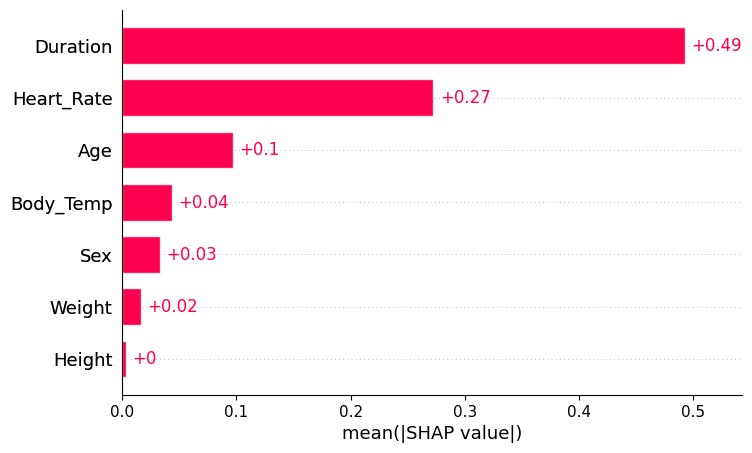

In [31]:
shap.plots.beeswarm(shap_values)  # summary plot
shap.plots.bar(shap_values)       # feature importance bar